In [1]:
import os
import sys
sys.path.append("..")

In [3]:
from model import YModel
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


In [4]:
from comet_ml import API
import comet_ml

%matplotlib inline

In [6]:
from collections import defaultdict
comet_api = API()
comet_api.get()

['shir994']

In [35]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values, hyper_params['data_size']])

In [19]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(1000))

In [42]:
metrics = defaultdict(lambda : defaultdict(list))
for experiment in comet_api.get("shir994/2d-convergence/"):
    hyper_params = {}
    for param in experiment.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] == '1000' and\
       hyper_params['TASK'] == '5':
        extract_metrics(experiment, hyper_params, metrics[hyper_params['data_size'] + "_" + hyper_params['TASK']], mask)

# GAN convergence

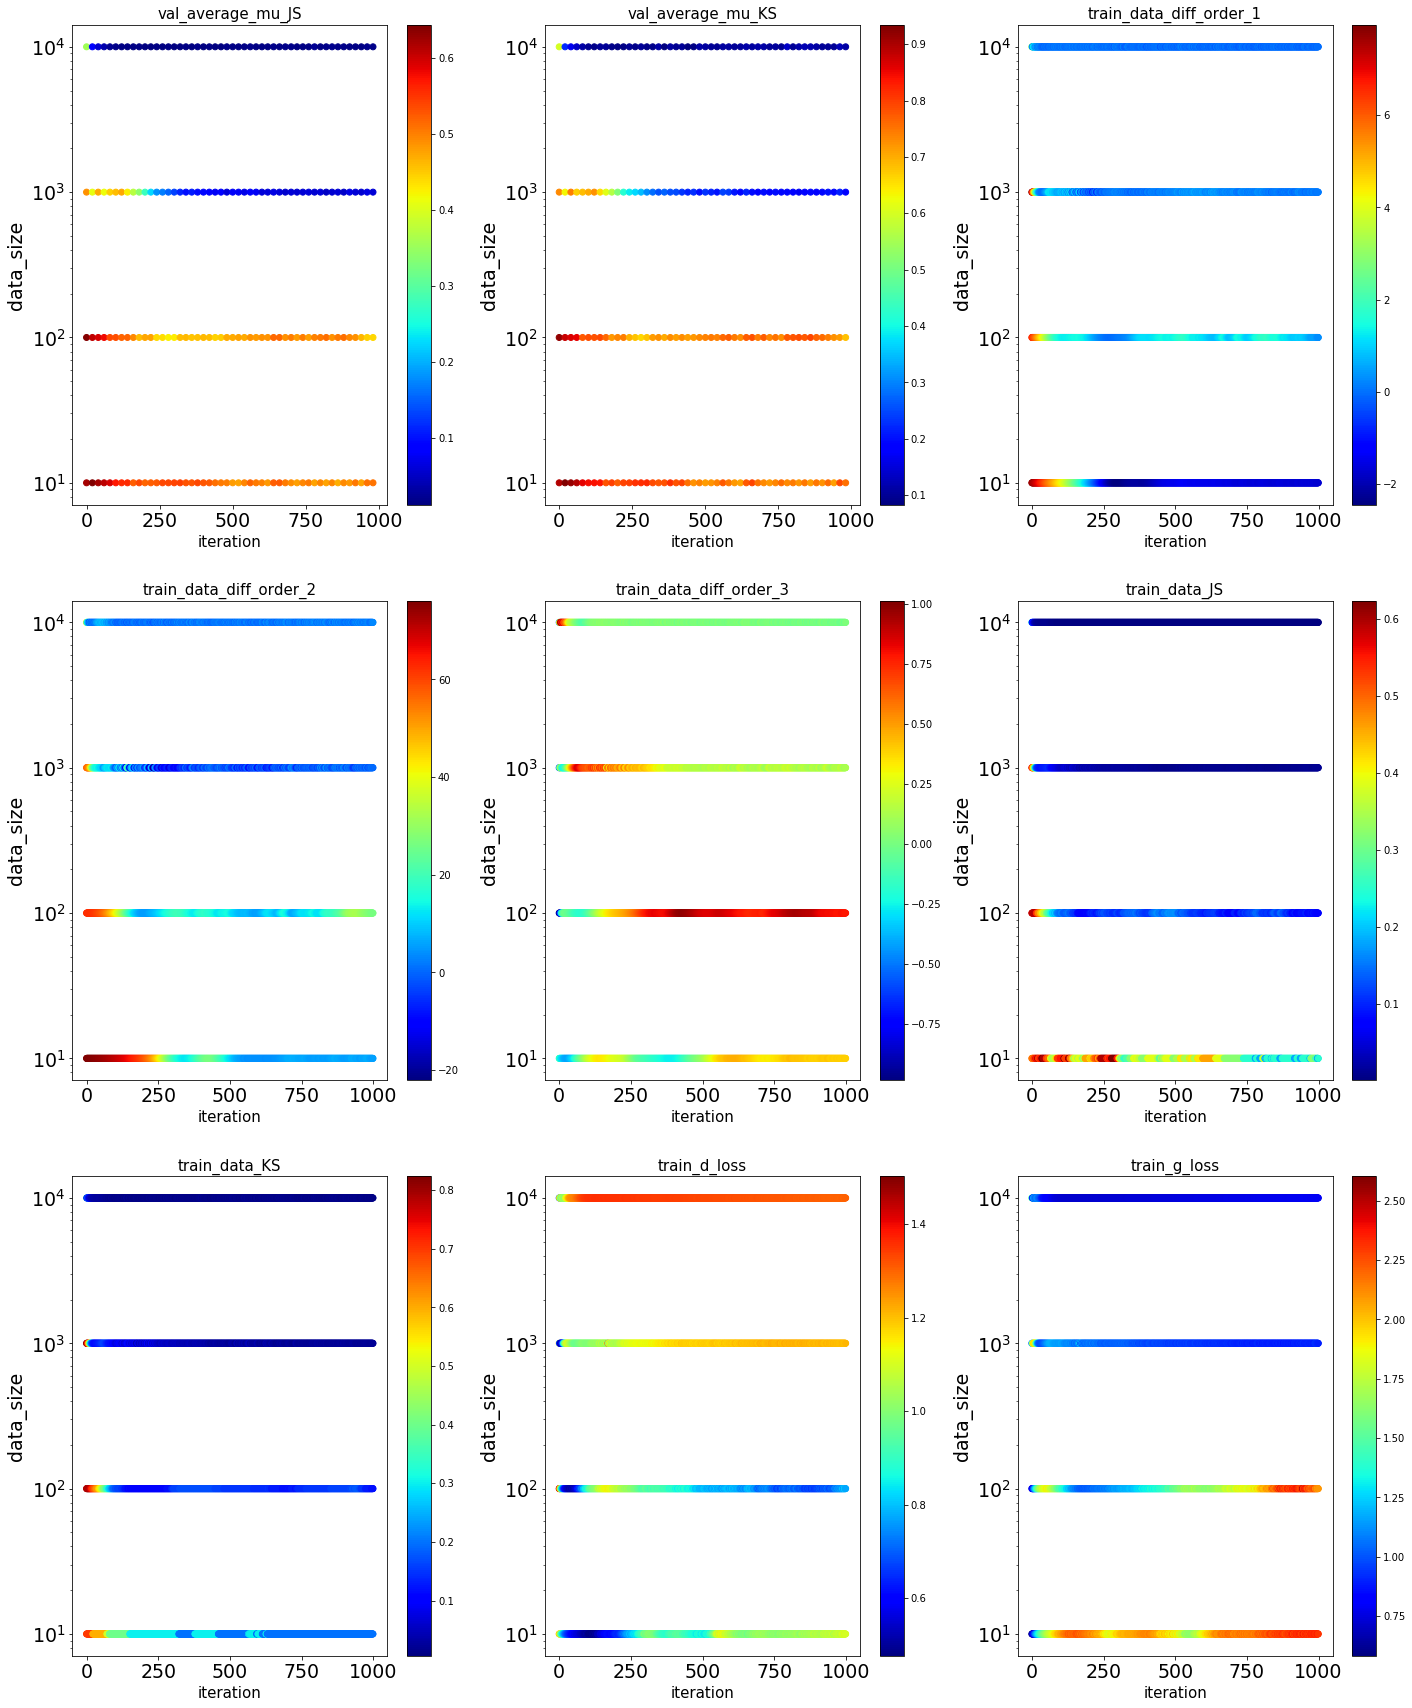

In [77]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')
plt.figure(figsize=(24,30))
index = 0
for metric in experiment.data['metrics']:
    if metric == "train_loss" or metric.startswith("train_data_gen"):
        continue
    plt.subplot(3,3, index + 1)
    index += 1
    
    data = []
    sizes = []
    iterations = []
    for key in metrics:
        data.append(metrics[key][metric][0][0])
        sizes.append([int(metrics[key][metric][0][1])] * metrics[key][metric][0][0].shape[0])
        iterations.append(np.arange(0, metrics[key][metric][0][0].shape[0]))
    
    if "average" in metric:
        metric = "val_" + "_".join(metric.split("_")[1:])
        iterations = np.array(iterations) * 20
        
    plt.scatter(iterations, np.array(sizes), c=data, cmap=my_cmap);#, norm=colors.LogNorm());
    plt.colorbar()
    plt.yscale("log")
    plt.title(metric, fontsize=15)
    plt.xlabel("iteration", fontsize=15)
    ax = plt.gca()
    ax.tick_params("both", labelsize=19)
    plt.ylabel("data_size", fontsize=19)


In [82]:
generators = {}
for exp in comet_api.get("shir994/2d-convergence/"):
    hyper_params = {}
    for param in exp.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] != '1000' or\
       hyper_params['TASK'] != '5':
        continue
        
    TASK = int(hyper_params['TASK'])
    NOISE_DIM = int(hyper_params["NOISE_DIM"])    

    generator = Generator(NOISE_DIM, out_dim = 1, input_param=3).to(device)
    if TASK == 4:
        discriminator = WSDiscriminator(in_dim=1).to(device)
    else:
        discriminator = Discriminator(in_dim=1, input_param=3).to(device) 

    import io

    asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] ==
                f"{hyper_params['data_size']}_999.tar"][0]
    params = exp.get_asset(asset_id)
    state_dict = torch.load(io.BytesIO(params))
    generator.load_state_dict(state_dict['gen_state_dict'])
    generators[hyper_params['data_size'] + "_" + hyper_params['TASK']] = generator

In [143]:
from itertools import product
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
mu = torch.tensor(np.array(list(product(x,y)))).float()
y_sampler = YModel()

noise_size = 1000

In [112]:
%%time

y_surf = {}
for key in generators:
    y_mean = np.zeros([len(mu), 1])
    for i in range(len(mu)):
        noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
        mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
        x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
        y_mean[i, 0] = generators[key](noise, torch.cat([mu_r,x_r],dim=1)).mean().item()
    y_surf[key] = y_mean

CPU times: user 2min 4s, sys: 1.2 s, total: 2min 5s
Wall time: 2min 6s


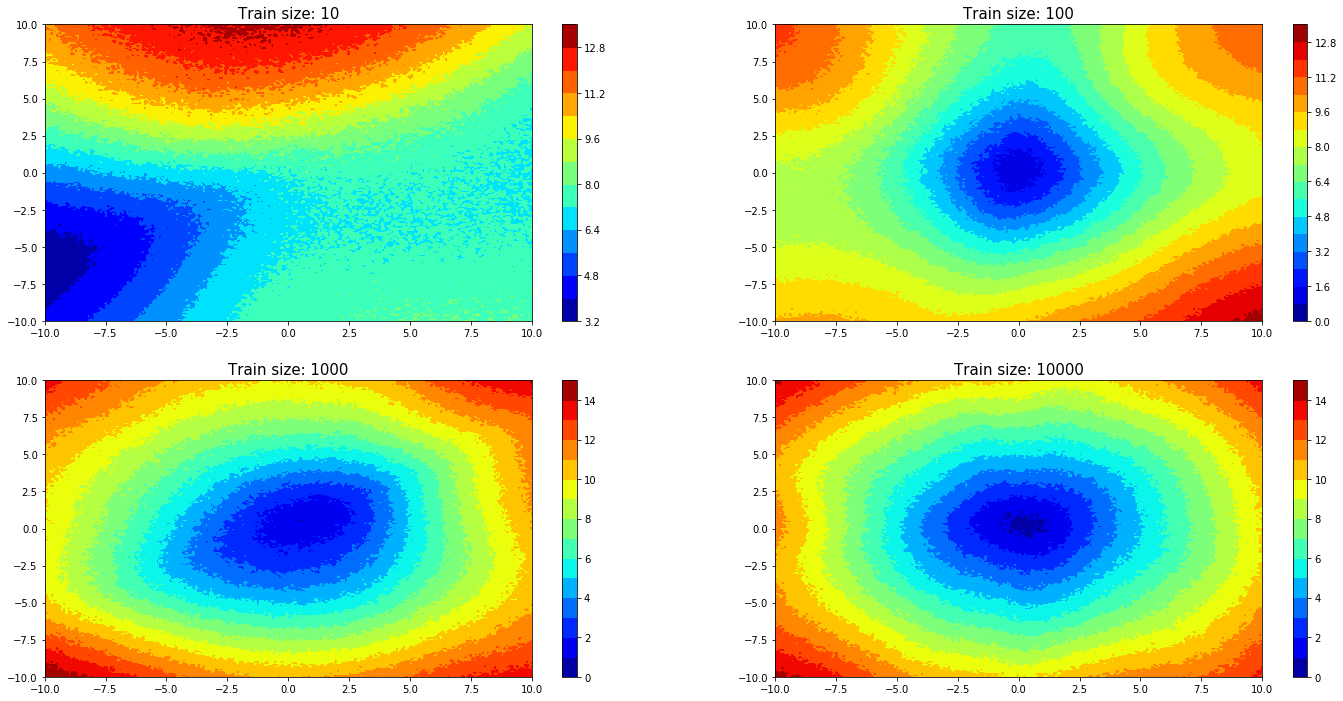

In [155]:
plt.figure(figsize=(24, 12))
for index, key in enumerate(y_surf):
    plt.subplot(2,2, index + 1)
    plt.contourf(*np.meshgrid(x,y), y_surf[key].reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
    plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
    plt.colorbar()

# Optimisation procedure

In [116]:
from model import OptLoss

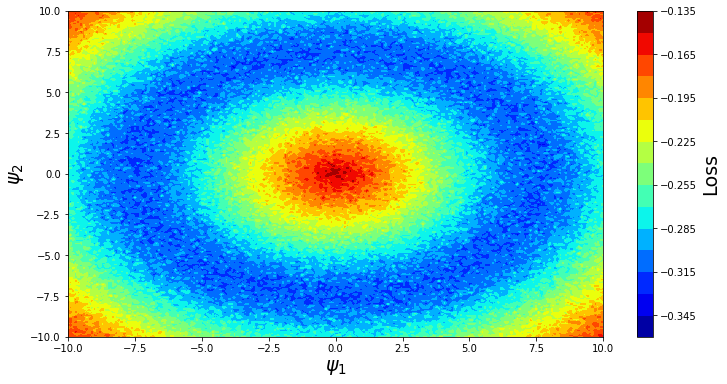

In [119]:
import numpy as np
plt.figure(figsize=(12,6))
#mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

#plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), rs.reshape(-1, x.shape[0]), cmap=my_cmap, levels=15)

cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

In [127]:
%%time

loss_surf = {}
for key in generators:
    loss_val = np.zeros([len(mu), 1])
    for i in range(len(mu)):
        noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
        mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
        x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
        samples = generators[key](noise, torch.cat([mu_r,x_r],dim=1))
        loss_val[i, 0] = OptLoss.SigmoidLoss(samples, 5, 10).mean().item()
    loss_surf[key] = loss_val

CPU times: user 2min 39s, sys: 1.2 s, total: 2min 40s
Wall time: 2min 40s


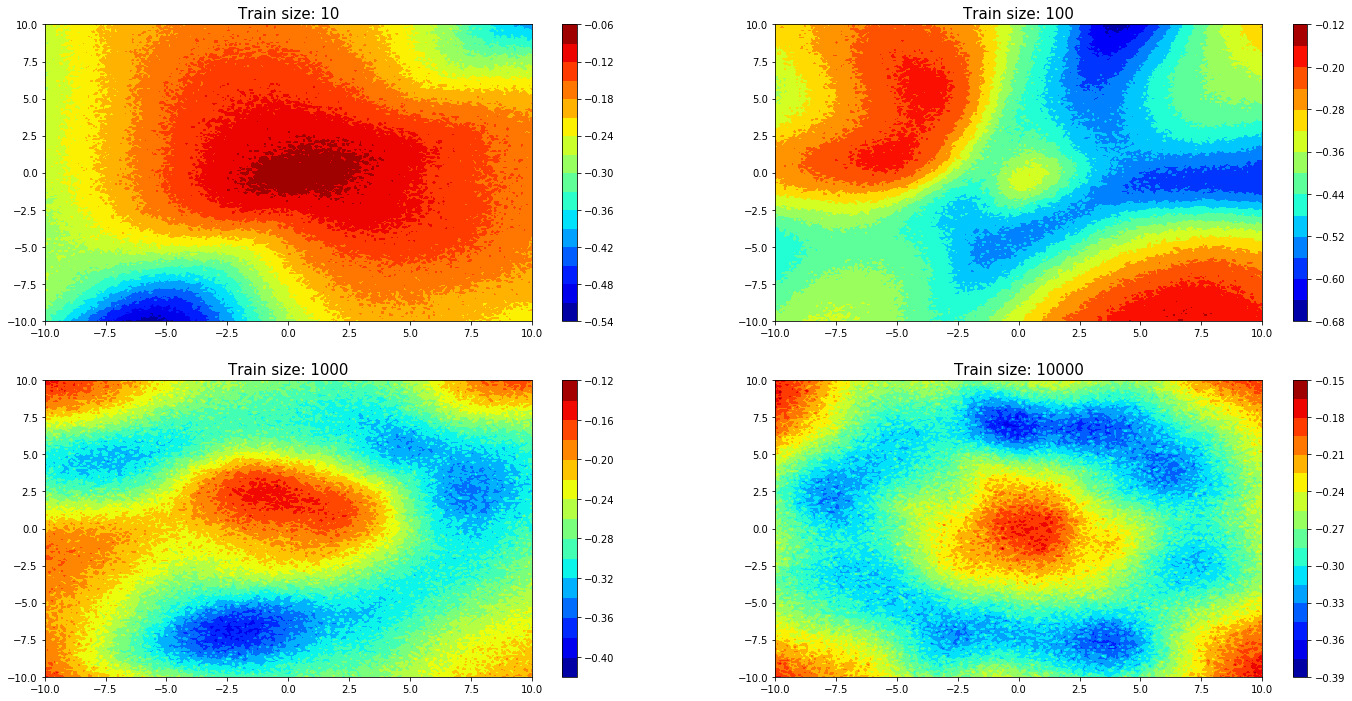

In [156]:
plt.figure(figsize=(24, 12))
for index, key in enumerate(loss_surf):
    plt.subplot(2,2, index + 1)
    plt.contourf(*np.meshgrid(x,y), loss_surf[key].reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
    plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
    plt.colorbar()

In [133]:
import pyro.distributions as dist

CPU times: user 9.88 s, sys: 88 ms, total: 9.96 s
Wall time: 9.97 s


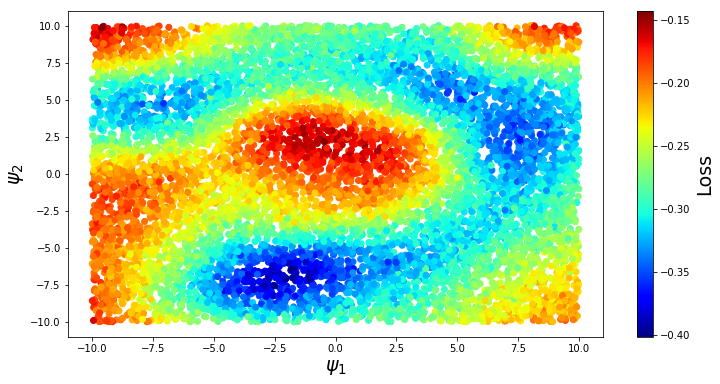

In [141]:
%%time
plt.figure(figsize=(12,6))
mu_range = (-10,10)
mu = dist.Uniform(*mu_range).sample([10000, 2]).to(device)

y = np.zeros([len(mu), 1])

rs = []
for i in range(len(mu)):
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    samples = generators['1000_5'](noise, torch.cat([mu_r,x_r],dim=1))
    rs.append(OptLoss.SigmoidLoss(samples, 5, 10).mean().item())

mu = mu.cpu().numpy()
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)